# Predicting CHOP inhibitors with 13C NMR spectroscopic data. Dataset 2.

## Content   <a name="content"></a>

1. [Upload and process H1 NMR spectroscopy data](#1)
2. [Create a dataframe merging the C13and H1 NMR data frames to the data frame holding the labels](#2)
3. [Ensure an equal number of classes in the test sets](#3)
4. [Balancing](#4)
5. [Machine Learning](#5)
6. [Five-fold cross validation](#6)
7. [Scrutinise for overfitting of the MLmodel with default hyperparameter values (kernel='rbf', C=1.0, gamma=’scale’](#7)
8. [Hyperparameter tununing by Optuna](#8)
9.  [Scrutinise for overfitting using hyperparameter tuned by Optuna](#9)
10. [Final ML model](#10)
11. [Plot the learning curve and ROC](#11)
12. [Confusion matrix, classification report and AUC](#12)

## Upload dataset with atomic features<a name="1"></a>

In [1]:
import pandas as pd

# load the converted nmr dataset
df_atmc_features = pd.read_csv('atomic_features_PubChem.csv', sep=';')

# Display the data frame
print('Shape of df_atmc_features: ',df_atmc_features.shape)
df_atmc_features.head()

Shape of df_atmc_features:  (20309, 8)


,CID,MW,TPSA,XLogP,DON,ACC,RBC,SMILES
0,6368310,286.29,96.6,0.7,2.0,5.0,5.0,C/C(=N/NC(=O)CNC(=O)C1=CC=NC=C1)/C2=CC=CO2
1,2151930,324.40,58.6,2.7,1.0,3.0,4.0,CC1=CC(=CC=C1)NC(=O)COC2=CC=CC3=C2CCN(C3=O)C
2,3243410,348.50,150.0,3.9,1.0,7.0,5.0,CC1=CC(=CC=C1)C2=NSC(=N2)SCC(=O)NC3=NC=CS3
3,4280557,431.50,110.0,4.0,1.0,6.0,8.0,CC(C)CN1C(=C(C(=O)N(C1=O)C)C(=O)COC(=O)CC23CC4...
4,2756596,191.19,68.0,1.0,1.0,4.0,2.0,CC(C(=O)O)N1C2=CC=CC=C2N=N1


[Back to top]

## Create a dataframe merging the NMR data frame to the data frame holding the labels  <a name="2"></a>

In [2]:
# load the dataset with targets
df_targets = pd.read_csv('input/targets.csv')

# Display the data frame
print('Shape of df_targets: ', df_targets.shape)
df_targets.head()

Shape of df_targets:  (20316, 2)


,SMILES,target
0,CCOC1=CC=C(C=C1)NC(=O)NNC(=O)C2=C(C=C(C=C2)Cl)Cl,0
1,CC(C(C)(C)C)NC(=S)NC1=CC(=C(C=C1)OC(F)F)Cl,0
2,CC1=C2CCCCC2=C3C(=C(SC3=N1)C(=O)N)N,0
3,CC1=CC2=C(C=C1)NC3=C2CCC4=C3NN=C4,0
4,CN(C)S(=O)(=O)C1=CC=C(C=C1)C2=CSC(=N2)N/N=C/C3...,0


In [3]:
# Merge the target and nmr data 
df = pd.merge( df_atmc_features, df_targets, on='SMILES', how='inner')

In [4]:
# Display the data frame
print('Shape of df: ', df.shape)
df.head()

Shape of df:  (19504, 9)


,CID,MW,TPSA,XLogP,DON,ACC,RBC,SMILES,target
0,6368310,286.29,96.6,0.7,2.0,5.0,5.0,C/C(=N/NC(=O)CNC(=O)C1=CC=NC=C1)/C2=CC=CO2,0
1,2151930,324.40,58.6,2.7,1.0,3.0,4.0,CC1=CC(=CC=C1)NC(=O)COC2=CC=CC3=C2CCN(C3=O)C,0
2,3243410,348.50,150.0,3.9,1.0,7.0,5.0,CC1=CC(=CC=C1)C2=NSC(=N2)SCC(=O)NC3=NC=CS3,1
3,4280557,431.50,110.0,4.0,1.0,6.0,8.0,CC(C)CN1C(=C(C(=O)N(C1=O)C)C(=O)COC(=O)CC23CC4...,1
4,2756596,191.19,68.0,1.0,1.0,4.0,2.0,CC(C(=O)O)N1C2=CC=CC=C2N=N1,0


In [5]:
# Drop categorical values
df.drop(columns=['CID','SMILES'], axis=1, inplace=True)

In [6]:
# Detect classes 
unique_count = df['target'].unique()
print("The unique values in column 'target:", unique_count)

The unique values in column 'target: [0 1]


In [7]:
# Drop rows with any NaN values
df = df.dropna()

In [8]:
# Count each of the binary targets
df['target'].value_counts()

target
0    11592
1     7909
Name: count, dtype: int64

[<a href="#content">Back to top</a>]

## Ensure an equal number of classes in the test sets <a name="3"></a>

In [9]:
# Handle the part of target 1 in the test set 
df_1 = df[df['target']==1]

# Shuffle the resulting data set
df_1 = df_1.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

# Extract 2800 samples (10% of 28000 samples) of target 1 for the test set
df_1_test = df_1.iloc[:2000]

# Assign the rest of target 1 for the train set
df_1_train = df_1.iloc[2000:]

In [10]:
# Handle the part of target 0 in the test set 
df_0 = df[df['target']==0]

# Shuffle the resulting data set
df_0 = df_0.sample(
    frac = 1,        # Return entire dataframe
    random_state=1   # Make result reproducible
    ).reset_index(drop=True)

## Extract 2800 samples (10% of 28000 samples) of target 0 for the test set Extract 10% of target 1 for the test set
df_0_test = df_0.iloc[:2000]

# Assign the rest of target 1 for the train set
df_0_train = df_0.iloc[2000:]

In [11]:
# Create train and test dataframe for further manipulation 
train = pd.concat([df_0_train, df_1_train])
test = pd.concat([df_0_test, df_1_test])

In [12]:
# Create the sets for ML 
X_train = train.drop(columns='target' , axis=1)
y_train = train['target']

X_test =  test.drop(columns='target' , axis=1)
y_test = test['target']

In [13]:
# Create X and y datasets to use for cross-validation
X = pd.concat([X_train, X_test]) 
y = pd.concat([y_train, y_test]) 

In [14]:
# Check the number of classes in the y_test set
y_test.value_counts()

target
0    2000
1    2000
Name: count, dtype: int64

In [15]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (15501, 6)
X_test:   (4000, 6)
y_train:  (15501,)
y_test:   (4000,)


[<a href="#content">Back to top</a>]

## Balancing <a name="4"></a>

[(0, 9592), (1, 5909)]


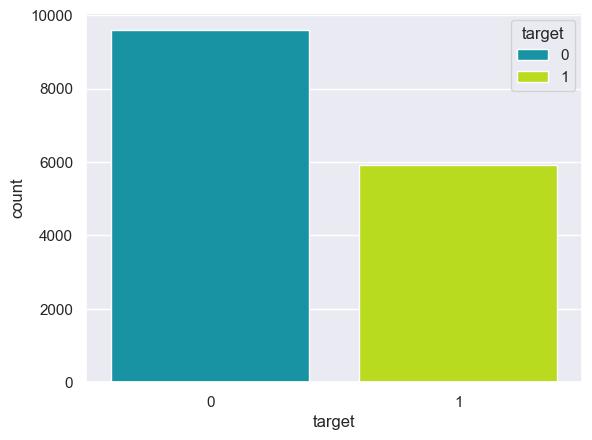

In [16]:
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

# Plot the imbalance between the targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train, palette='nipy_spectral')
plt.show()

[(0, 9592), (1, 9592)]


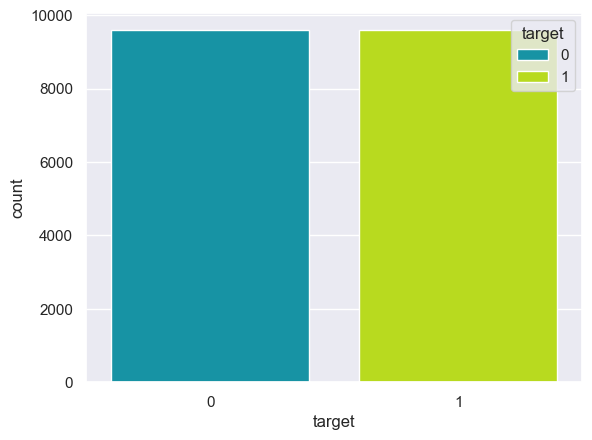

In [17]:
from imblearn.over_sampling import RandomOverSampler

# Balance targets with Synthetic Minority Oversampling Technique
ros = RandomOverSampler()

X_train, y_train = ros.fit_resample(X_train, y_train)

# Plot the balance between classification targets 
print(sorted(Counter(y_train).items()))
sns.set_style('white')
sns.set(font_scale=1)
plt.figure()
sns.countplot(x=y_train, hue=y_train,palette='nipy_spectral')
plt.show()

In [18]:
# Print the shape of each part
print("Shapes:")
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test:  ", y_test.shape)

Shapes:
X_train:  (19184, 6)
X_test:   (4000, 6)
y_train:  (19184,)
y_test:   (4000,)


[<a href="#content">Back to top</a>]

## Machine Learning <a name="5"></a>

In [19]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Instantiate the algorithms that will be used, placing them in a dictionary 
clfs = {"SVM":SVC(),
        "Decision":DecisionTreeClassifier(), 
        "RandomForest":RandomForestClassifier(), 
        "GradientBoost":GradientBoostingClassifier(),
        "K-nearest": KNeighborsClassifier(n_neighbors=3)}

In [20]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

# Create statistics with the results of training with different algorithms
def model_fit(clfs):
    fitted_model={}
    model_result = pd.DataFrame()
    # Iterate the clfs dictionary clfs
    for model_name, model in clfs.items():
        # Train the current model
        model.fit(X_train,y_train)
        # Add the current model name
        fitted_model.update({model_name:model})
        # Prediction of the current model 
        y_pred = model.predict(X_test)
        model_dict = {}
        model_dict['1.Algorithm'] = model_name
        # Calculate the metrics
        model_dict['2.Accuracy'] = round(accuracy_score(y_test, y_pred),3)
        model_dict['3.Precision'] = round(precision_score(y_test, y_pred),3)
        model_dict['4.Recall'] = round(recall_score(y_test, y_pred),3)
        model_dict['5.F1'] = round(f1_score(y_test, y_pred),3)
        model_dict['6.ROC'] = round(roc_auc_score(y_test, y_pred),3)
        model_result = model_result._append(model_dict,ignore_index=True)
    return fitted_model, model_result

# Run the function model_fit(clfs) 
fitted_model, model_result = model_fit(clfs)

# Display the results of the model_fit(clfs) function in a descending order
model_result.sort_values(by=['2.Accuracy'],ascending=False)

,1.Algorithm,2.Accuracy,3.Precision,4.Recall,5.F1,6.ROC
3,GradientBoost,0.807,0.826,0.778,0.801,0.807
2,RandomForest,0.803,0.850,0.737,0.790,0.804
0,SVM,0.764,0.857,0.634,0.729,0.764
1,Decision,0.752,0.785,0.694,0.737,0.752
4,K-nearest,0.729,0.739,0.708,0.723,0.729


[<a href="#content">Back to top</a>]

## Five-fold cross-validation  <a name="6"></a>

In [21]:
# Cross validation
from sklearn.model_selection import cross_val_score
import numpy as np

# Create statistics with the results of the cross-validation of different estimators
def model_CV(clfs):
    estimated_model={}
    model_cv_result = pd.DataFrame()
    for model_name, model in clfs.items():
        estimated_model.update({model_name:model})
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        model_dict = {}
        model_dict['1.Algorithm'] = model_name
        model_dict['2.Mean CV Score'] = round(scores.mean(), 4)
        model_dict['3.Standard Deviation'] = round(scores.std(), 4)
        model_dict['4.List of CV Scores'] = np.round(scores, 4)
        model_cv_result = model_cv_result._append(model_dict,ignore_index=True)
    return estimated_model, model_cv_result

# Run the model_CV(clsf) function
estimated_model, model_cv_result = model_CV(clfs)

# Display the results of cross_validation statistics in a descending order
model_cv_result.sort_values(by=['2.Mean CV Score'],ascending=False)

,1.Algorithm,2.Mean CV Score,3.Standard Deviation,4.List of CV Scores
2,RandomForest,0.8871,0.0286,"[0.866, 0.8676, 0.8593, 0.9132, 0.9296]"
1,Decision,0.8416,0.0296,"[0.8183, 0.8165, 0.8189, 0.8679, 0.8863]"
3,GradientBoost,0.8099,0.0038,"[0.8053, 0.8165, 0.8082, 0.8087, 0.811]"
4,K-nearest,0.7810,0.0221,"[0.7615, 0.7688, 0.7589, 0.8071, 0.8084]"
0,SVM,0.7660,0.0031,"[0.7626, 0.7696, 0.767, 0.7686, 0.762]"


[<a href="#content">Back to top</a>]

## Scrutinise for overfitting  <a name="7"></a>

In [22]:
# Evaluate random forest classifier performance on train and test sets with different tree depths
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 31)]
# evaluate a decision tree for each depth
for i in values:
 # configure the model
 model_ = RandomForestClassifier(max_depth=i)
 # fit model_ on the training dataset
 model_.fit(X_train, y_train)
 # evaluate on the train dataset
 train_yhat = model_.predict(X_train)
 train_acc = accuracy_score(y_train, train_yhat)
 train_scores.append(train_acc)
 # evaluate on the test dataset
 test_yhat = model_.predict(X_test)
 test_acc = accuracy_score(y_test, test_yhat)
 test_scores.append(test_acc)
 # summarize progress
 print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

>1, train: 0.791, test: 0.791
>2, train: 0.795, test: 0.796
>3, train: 0.797, test: 0.795
>4, train: 0.803, test: 0.799
>5, train: 0.808, test: 0.802
>6, train: 0.814, test: 0.805
>7, train: 0.819, test: 0.806
>8, train: 0.826, test: 0.805
>9, train: 0.837, test: 0.806
>10, train: 0.853, test: 0.806
>11, train: 0.869, test: 0.804
>12, train: 0.891, test: 0.807
>13, train: 0.912, test: 0.806
>14, train: 0.934, test: 0.805
>15, train: 0.955, test: 0.805
>16, train: 0.970, test: 0.805
>17, train: 0.982, test: 0.802
>18, train: 0.990, test: 0.805
>19, train: 0.993, test: 0.806
>20, train: 0.996, test: 0.802
>21, train: 0.998, test: 0.805
>22, train: 0.998, test: 0.800
>23, train: 0.999, test: 0.805
>24, train: 0.999, test: 0.801
>25, train: 0.999, test: 0.801
>26, train: 0.999, test: 0.804
>27, train: 0.999, test: 0.803
>28, train: 0.999, test: 0.801
>29, train: 0.999, test: 0.804
>30, train: 0.999, test: 0.800


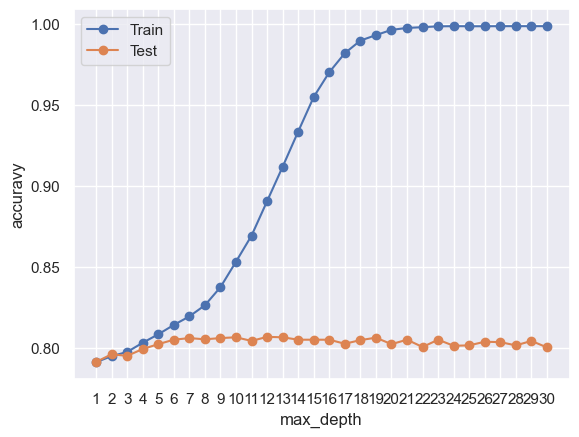

In [23]:
import math
import matplotlib.pyplot as plt

# Set integers for x axis
new_x_ticks = range(math.floor(min(values)), math.ceil(max(values))+1)
plt.xticks(new_x_ticks)
# Plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuravy")
plt.show()

[<a href="#content">Back to top</a>]

## Scrutinise for overfitting of the model hyperparameter tuned by Optuna <a name="8"></a>

In [24]:
# Scrutinise for overfitting
fr sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

# Create an SVM model with hyperparamenters runed by Optuna
model = SVC(kernel='rbf',
            C=493.2744094205687,
            gamma=0.00040591543979010816) 

# Calculate training accuracy using cross-validation
train_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
train_accuracy = train_scores.mean()

# Train the model on the entire training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Check for overfitting
if train_accuracy - test_accuracy > 0.1:  # Example threshold, adjust as needed
    print("Warning: Potential overfitting detected.")
    print("Train accuracy:", train_accuracy)
    print("Test accuracy:", test_accuracy)
else:
    print("No significant overfitting detected.")
    print("Train accuracy:", train_accuracy)
    print("Test accuracy:", test_accuracy)

SyntaxError: invalid syntax (2940982567.py, line 2)

[<a href="#content">Back to top</a>]

## Final ML model <a name="9"></a>

In [ ]:
# Instantiate the final model
model = SVC(kernel='rbf', C=1, probability=True)

In [ ]:
# Calculate training accuracy using cross-validation
train_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
train_accuracy = train_scores.mean()

# Train the model on the entire training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Check for overfitting
if train_accuracy - test_accuracy > 0.1:  # Example threshold, adjust as needed
    print("Warning: Potential overfitting detected.")
    print("Train accuracy:", train_accuracy)
    print("Test accuracy:", test_accuracy)
else:
    print("No significant overfitting detected.")
    print("Train accuracy:", train_accuracy)
    print("Test accuracy:", test_accuracy)

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("Cross-validation scores:", np.round(scores, 3))
print("Mean cross-validation score:", np.round(scores.mean(), 3))

In [ ]:
# ML 
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
acc = round(accuracy_score(y_test, y_pred),3)
print('Accuracy: ', acc)
pre = round(precision_score(y_test, y_pred),3)
print('Precision: ', pre) 
rec = round(recall_score(y_test, y_pred),3)
print('Recall: ',rec) 
f1 = round(f1_score(y_test, y_pred),3)
print('F1: ', f1) 
roc = round(roc_auc_score(y_test, y_pred),3) 
print('ROC: ', roc)

[<a href="#content">Back to top</a>]

## Plot the learning curve and ROC  <a name="10"></a>

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="b",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, "o-", color="b", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [ ]:
from sklearn.metrics import RocCurveDisplay

svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

[<a href="#content">Back to top</a>]

## Confusion matrix, classification report and AUC <a name="11"></a>

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# SVC prediction
predicted = model.fit(X_train, y_train).predict(X_test)

# Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, predicted)

# Display confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
# Classification report 
from sklearn.metrics import classification_report

# Print the classification report 
target_names = ['Active (target 1) ', 'Inactive (target 0)']
print(classification_report(y_test, predicted, target_names=target_names))

[<a href="#content">Back to top</a>]